<a href="https://colab.research.google.com/github/amirazaiz/Pix2Pix_GAN/blob/main/Pix2Pix_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Generator: U_net
 encoder: C64-C128-C256-C512-C512-C512-C512-C512
 decoder: CD512-CD512-CD512-C512-C256-C128-C64

 Discriminator: PatchGAN
 C64-C128-C256-C512
 After the last layer a convolution is applied to map to a 1-dimensional output followed by a Sigmoid function.

# Importing the libraries

In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from numpy.random import randn,randint
from numpy import zeros,ones,expand_dims

In [ ]:
from keras.layers import Input,Dense,Reshape,Flatten,BatchNormalization,LeakyReLU,Conv2D,Dropout,Conv2DTranspose,Embedding,Concatenate,Activation
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
from tensorflow.keras.utils import plot_model
from keras.initializers import RandomNormal

In [ ]:
import matplotlib.pyplot as plt
import cv2 
def imshow(title,image):
  plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  plt.title(title)

# Discriminator

In [ ]:
def define_discriminator(image_shape):

  # weight initialization
  init = RandomNormal(stddev=0.02)

  # the two input images
  in_src_image = Input(shape=image_shape)
  in_target_image = Input(shape=image_shape)

  # concatentenate the two input images
  merged = Concatenate()([in_src_image,in_target_image])

  # PatchGAN architecture

  d =Conv2D(64,(4,4), strides=(2,2), padding="same",kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  
  d =Conv2D(128,(4,4), strides=(2,2), padding="same",kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d =Conv2D(256,(4,4), strides=(2,2), padding="same",kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d =Conv2D(512,(4,4), strides=(2,2), padding="same",kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  # Patch output
  d = Conv2D(1,(4,4),padding="same",kernel_initializer=init)(d)
  patch_out = Activation("sigmoid")(d)

  model = Model([in_src_image,in_target_image],patch_out)

  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(optimizer=opt,loss="binary_crossentropy",metrics=['accuracy'],loss_weights=[0.5])

  return model 

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


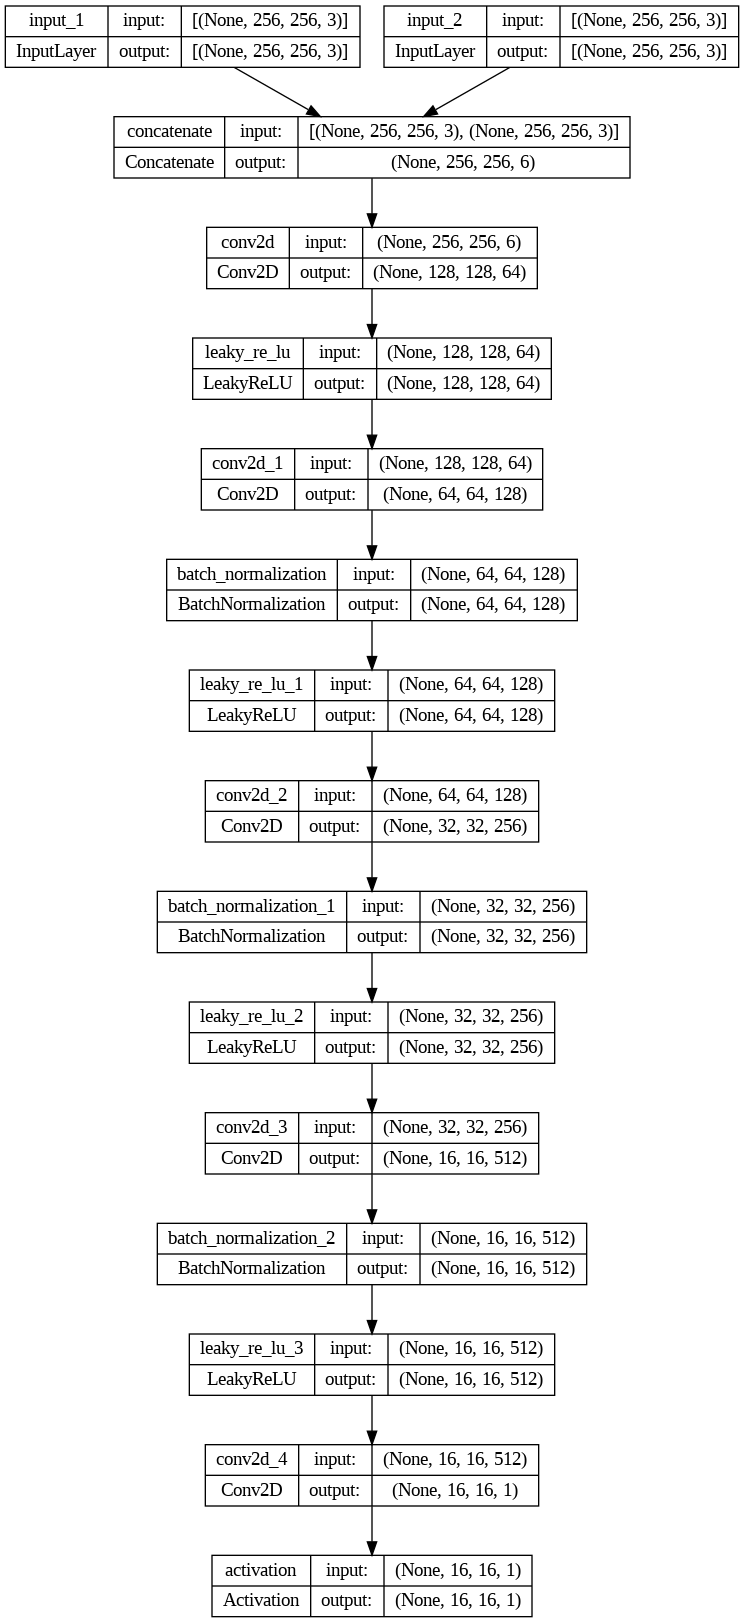

In [ ]:
d = define_discriminator((256,256,3))
plot_model(d, to_file='d_model.png', show_shapes=True)

# Encoder

In [ ]:
def define_encoder_block(layer_in,n_filters,batchnorm=True):
  init = RandomNormal(stddev=0.02)
  g = Conv2D(n_filters, (4,4), strides=(2,2),padding="same",kernel_initializer=init)(layer_in)
  if batchnorm:
    g = BatchNormalization()(g,training=True)
  g = LeakyReLU(alpha=0.2)(g)

  return g

# Decoder

In [ ]:
def define_decoder_block(layer_in,skip_in, n_filters, dropout=True):
  init =  RandomNormal(stddev=0.02)
  g = Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding="same", kernel_initializer=init)(layer_in)
  g = BatchNormalization()(g,training=True)
  if dropout:
    g = Dropout(0.5)(g,training=True)
  g = Concatenate()([g,skip_in])
  g = Activation('relu')(g)

  return g


# U-NET Generator

In [ ]:
def define_generator(image_shape=(256,256,3)):
  init = RandomNormal(stddev=0.02)

  in_image = Input(shape=image_shape)
  # encoder model C64-C128-C256-C512-C512-C512-C512-C512
  e1 = define_encoder_block(in_image,64,batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  # bottleneck no batch_norm and relu
  b = Conv2D(512,(4,4),strides=(2,2),padding="same", kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  # decoder CD512-CD512-CD512-C512-C256-C128-C64
  d1 = define_decoder_block(b, e7, 512)
  d2 = define_decoder_block(d1, e6, 512)
  d3 = define_decoder_block(d2, e5, 512)
  d4 = define_decoder_block(d3, e4, 512, dropout=False)
  d5 = define_decoder_block(d4, e3, 256, dropout=False)
  d6 = define_decoder_block(d5, e2, 128, dropout=False)
  d7 = define_decoder_block(d6, e1, 64, dropout=False)

  # output 
  g = Conv2DTranspose(image_shape[2],(4,4),strides=(2,2),padding="same",kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)

  model = Model(in_image, out_image)
  return model


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


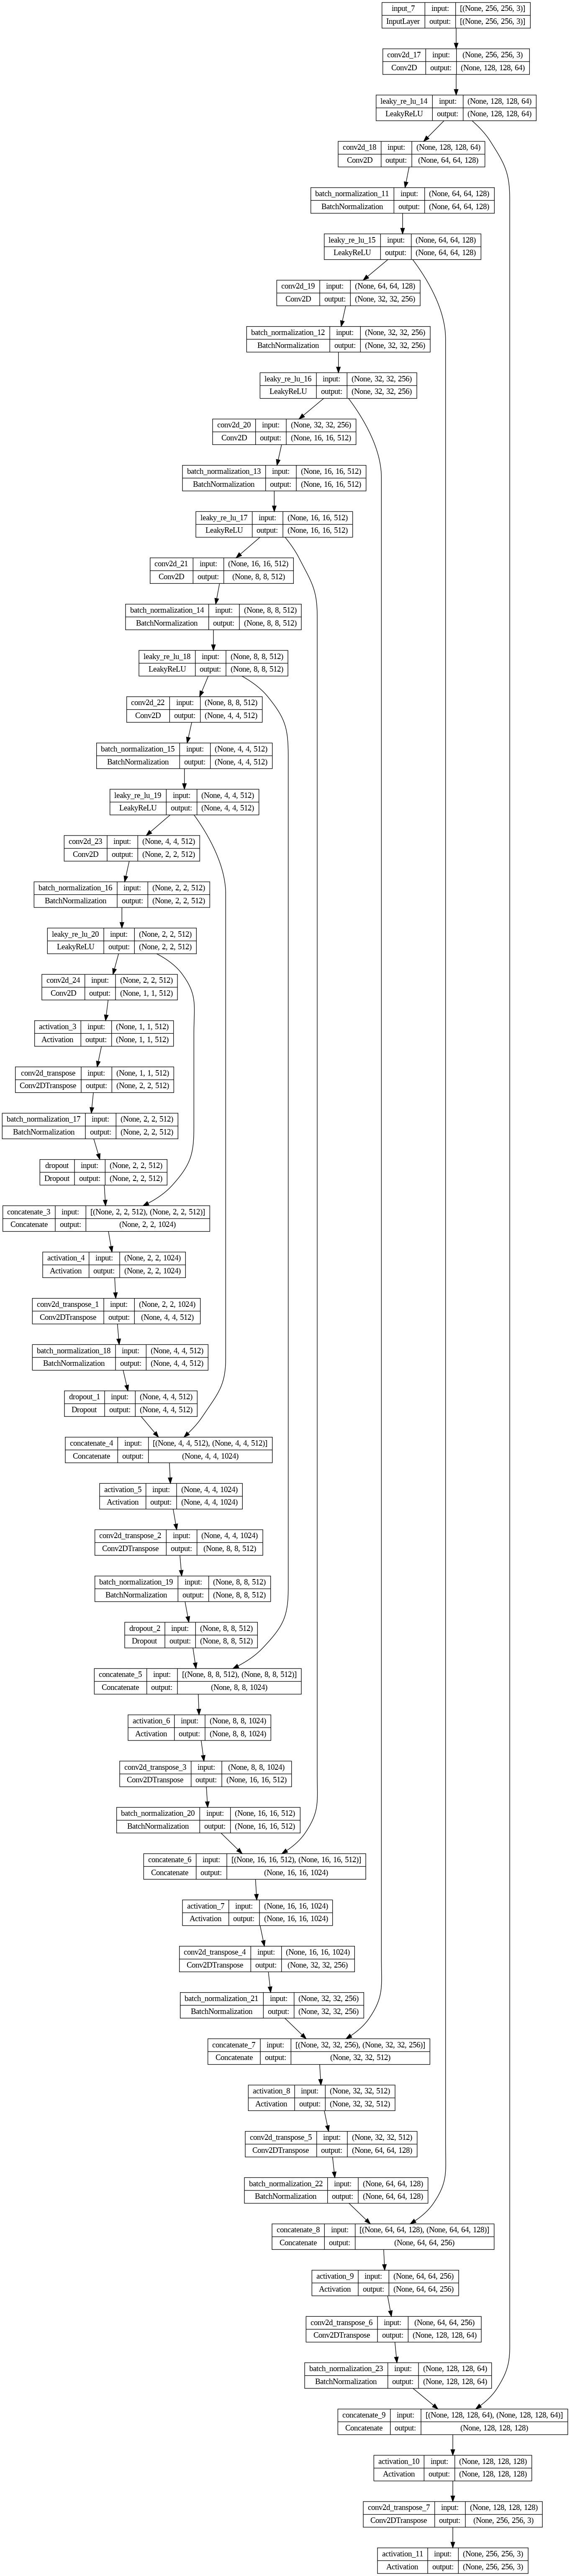

In [ ]:
g = define_generator((256,256,3))
plot_model(g, to_file='g_model.png', show_shapes=True)

# GAN

In [ ]:
def define_gan(g_model,d_model,image_shape):
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  
  in_src = Input(shape=image_shape)
  gen_out = g_model(in_src)
  disc_out = d_model([in_src,gen_out])

  model = Model(in_src,[disc_out,gen_out])

  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(optimizer=opt,loss=["binary_crossentropy","mae"],metrics=['accuracy'],loss_weights=[1,100])

  return model

# Useful functions for training our GAN

In [ ]:
def generate_real_samples(dataset, n_samples,patch_shape):
  trainA, trainB = dataset
  ix = randint(0,trainA.shape[0],n_samples)
  X1, X2 = trainA[ix], trainB[ix]
  y = ones((n_samples, patch_shape,patch_shape,1))

  return [X1,X2], y

In [ ]:
def generate_fake_samples(g_model,samples,patch_shape):
  X = g_model.predict(samples)
  y = zeros((len(X),patch_shape,patch_shape,1))

  return X, y

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
  # select a sample of input images
  [X_realA,X_realB], _ = generate_real_samples(dataset, n_samples,1)
  # generate a batch of fake images
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1) 
  # scale pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1 ) / 2.0
  X_realB = (X_realB + 1 ) / 2.0
  X_fakeB = (X_fakeB + 1 ) / 2.0

  # plot real src images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1+i)
    plt.axis("off")
    plt.imshow(X_realA[i])
  # plot generated target images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1+n_samples +i)
    plt.axis("off")
    plt.imshow(X_fakeB[i]) 
  # plot real target images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1+n_samples*2 +i)
    plt.axis("off")
    plt.imshow(X_realB[i])
  # save plot to file
  filename1 = "plot_%06d.png" % (step+1)
  plt.savefig(filename1)
  plt.close()

  # save generator model
  filename2 = "model_%06d.h5" % (step+1)
  g_model.save(filename2)

  print('>Saved: %s and %s' % (filename1,filename2))

In [ ]:
def train(d_model,g_model,gan_model,dataset,n_epochs=100,n_batch=1):
  n_patch = d_model.output_shape[1]
  trainA, trainB = dataset
  bat_per_epo = int(len(trainA)/n_batch)
  n_steps = bat_per_epo * n_epochs

  for i in range(n_steps):
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)  
    X_fakeB , y_fake = generate_fake_samples(g_model, X_realA, n_patch)

    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    
    g_loss = gan_model.train_on_batch(X_realA, [y_real,X_realB])
    print(i + 1)

    
    # print('>%d, d1[%.3f] d2[%.3f] g[%.3f] ' % (i+1,d_loss1, d_loss2, g_loss))

    # print(f'{i+1}{d_loss1}{d_loss2} {g_loss}')

    if (i+1) % (bat_per_epo) ==0:
      summarize_performance(i, g_model,dataset)

# Loading the dataset & Preprocessing images

In [ ]:
from os import listdir
from numpy import asarray,load,vstack,savez_compressed
# from keras.preprocessing.image import  load_img
from tensorflow.keras.utils import img_to_array,load_img

In [ ]:
def load_images(path,size=(256,512)):
  src_list,tar_list = list(), list()

  for filename in listdir(path):
    pixels = load_img(path + filename, target_size = size)
    pixels = img_to_array(pixels)
    
    sat_img, map_img = pixels[:,:256], pixels[:, 256:]

    src_list.append(sat_img)
    tar_list.append(map_img)
  return [asarray(src_list), asarray(tar_list)]

In [ ]:
path = "/content/drive/MyDrive/0-myComputerVisionProjects/maps/train/"

In [ ]:
[src_images, tar_images] = load_images(path)
print(src_images.shape, tar_images.shape)

(1096, 256, 256, 3) (1096, 256, 256, 3)


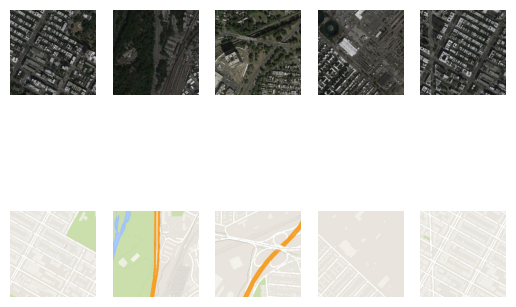

In [ ]:
n_samples = 5
for i in range(n_samples):
  plt.subplot(2,n_samples, 1 + i)
  plt.axis('off')
  plt.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
  plt.subplot(2,n_samples, 1 + i + n_samples)
  plt.axis('off')
  plt.imshow(tar_images[i].astype('uint8'))
plt.show()

# defining gan

In [ ]:
image_shape = src_images.shape[1:]
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

def preprocess_data(data):
  X1 ,X2 = data[0], data[1]
  X1 = ( X1 - 127.5)/127.5
  X2 = ( X2 - 127.5)/127.5
  return [X1, X2]

In [ ]:
data = [src_images, tar_images]
dataset = preprocess_data(data)

In [ ]:
train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=10)

1/1 [==============================] - 2s 2s/step
1
1/1 [==============================] - 0s 43ms/step
2
1/1 [==============================] - 0s 34ms/step
3
1/1 [==============================] - 0s 39ms/step
4
1/1 [==============================] - 0s 35ms/step
5
1/1 [==============================] - 0s 35ms/step
6
1/1 [==============================] - 0s 24ms/step
7
1/1 [==============================] - 0s 24ms/step
8
1/1 [==============================] - 0s 25ms/step
9
1/1 [==============================] - 0s 27ms/step
10
1/1 [==============================] - 0s 27ms/step
11
1/1 [==============================] - 0s 26ms/step
12
1/1 [==============================] - 0s 24ms/step
13
1/1 [==============================] - 0s 23ms/step
14
1/1 [==============================] - 0s 24ms/step
15
1/1 [==============================] - 0s 24ms/step
16
1/1 [==============================] - 0s 25ms/step
17
1/1 [==============================] - 0s 24ms/step
18
1/1 [================

>Saved: plot_000109.png and model_000109.h5
1/1 [==============================] - 0s 24ms/step
110
1/1 [==============================] - 0s 26ms/step
111
1/1 [==============================] - 0s 24ms/step
112
1/1 [==============================] - 0s 24ms/step
113
1/1 [==============================] - 0s 25ms/step
114
1/1 [==============================] - 0s 23ms/step
115
1/1 [==============================] - 0s 24ms/step
116
1/1 [==============================] - 0s 24ms/step
117
1/1 [==============================] - 0s 25ms/step
118
1/1 [==============================] - 0s 25ms/step
119
1/1 [==============================] - 0s 26ms/step
120
1/1 [==============================] - 0s 24ms/step
121
1/1 [==============================] - 0s 26ms/step
122
1/1 [==============================] - 0s 24ms/step
123
1/1 [==============================] - 0s 25ms/step
124
1/1 [==============================] - 0s 38ms/step
125
1/1 [==============================] - 0s 25ms/step
126
1/1 

>Saved: plot_000218.png and model_000218.h5
1/1 [==============================] - 0s 29ms/step
219
1/1 [==============================] - 0s 28ms/step
220
1/1 [==============================] - 0s 31ms/step
221
1/1 [==============================] - 0s 28ms/step
222
1/1 [==============================] - 0s 35ms/step
223
1/1 [==============================] - 0s 28ms/step
224
1/1 [==============================] - 0s 28ms/step
225
1/1 [==============================] - 0s 39ms/step
226
1/1 [==============================] - 0s 44ms/step
227
1/1 [==============================] - 0s 42ms/step
228
1/1 [==============================] - 0s 41ms/step
229
1/1 [==============================] - 0s 43ms/step
230
1/1 [==============================] - 0s 30ms/step
231
1/1 [==============================] - 0s 34ms/step
232
1/1 [==============================] - 0s 29ms/step
233
1/1 [==============================] - 0s 28ms/step
234
1/1 [==============================] - 0s 29ms/step
235
1/1 

>Saved: plot_000327.png and model_000327.h5
1/1 [==============================] - 0s 40ms/step
328
1/1 [==============================] - 0s 41ms/step
329
1/1 [==============================] - 0s 39ms/step
330
1/1 [==============================] - 0s 24ms/step
331
1/1 [==============================] - 0s 23ms/step
332
1/1 [==============================] - 0s 24ms/step
333
1/1 [==============================] - 0s 23ms/step
334
1/1 [==============================] - 0s 24ms/step
335
1/1 [==============================] - 0s 27ms/step
336
1/1 [==============================] - 0s 24ms/step
337
1/1 [==============================] - 0s 29ms/step
338
1/1 [==============================] - 0s 24ms/step
339
1/1 [==============================] - 0s 31ms/step
340
1/1 [==============================] - 0s 24ms/step
341
1/1 [==============================] - 0s 25ms/step
342
1/1 [==============================] - 0s 26ms/step
343
1/1 [==============================] - 0s 24ms/step
344
1/1 

>Saved: plot_000436.png and model_000436.h5
1/1 [==============================] - 0s 25ms/step
437
1/1 [==============================] - 0s 25ms/step
438
1/1 [==============================] - 0s 25ms/step
439
1/1 [==============================] - 0s 25ms/step
440
1/1 [==============================] - 0s 24ms/step
441
1/1 [==============================] - 0s 26ms/step
442
1/1 [==============================] - 0s 24ms/step
443
1/1 [==============================] - 0s 26ms/step
444
1/1 [==============================] - 0s 24ms/step
445
1/1 [==============================] - 0s 23ms/step
446
1/1 [==============================] - 0s 24ms/step
447
1/1 [==============================] - 0s 24ms/step
448
1/1 [==============================] - 0s 27ms/step
449
1/1 [==============================] - 0s 26ms/step
450
1/1 [==============================] - 0s 25ms/step
451
1/1 [==============================] - 0s 39ms/step
452
1/1 [==============================] - 0s 37ms/step
453
1/1 

>Saved: plot_000545.png and model_000545.h5
1/1 [==============================] - 0s 25ms/step
546
1/1 [==============================] - 0s 24ms/step
547
1/1 [==============================] - 0s 31ms/step
548
1/1 [==============================] - 0s 24ms/step
549
1/1 [==============================] - 0s 24ms/step
550
1/1 [==============================] - 0s 45ms/step
551
1/1 [==============================] - 0s 39ms/step
552
1/1 [==============================] - 0s 67ms/step
553
1/1 [==============================] - 0s 52ms/step
554
1/1 [==============================] - 0s 80ms/step
555
1/1 [==============================] - 0s 57ms/step
556
1/1 [==============================] - 0s 64ms/step
557
1/1 [==============================] - 0s 42ms/step
558
1/1 [==============================] - 0s 24ms/step
559
1/1 [==============================] - 0s 27ms/step
560
1/1 [==============================] - 0s 25ms/step
561
1/1 [==============================] - 0s 27ms/step
562
1/1 

>Saved: plot_000654.png and model_000654.h5
1/1 [==============================] - 0s 32ms/step
655
1/1 [==============================] - 0s 30ms/step
656
1/1 [==============================] - 0s 30ms/step
657
1/1 [==============================] - 0s 32ms/step
658
1/1 [==============================] - 0s 29ms/step
659
1/1 [==============================] - 0s 30ms/step
660
1/1 [==============================] - 0s 29ms/step
661
1/1 [==============================] - 0s 29ms/step
662
1/1 [==============================] - 0s 31ms/step
663
1/1 [==============================] - 0s 34ms/step
664
1/1 [==============================] - 0s 30ms/step
665
1/1 [==============================] - 0s 32ms/step
666
1/1 [==============================] - 0s 36ms/step
667
1/1 [==============================] - 0s 28ms/step
668
1/1 [==============================] - 0s 39ms/step
669
1/1 [==============================] - 0s 46ms/step
670
1/1 [==============================] - 0s 55ms/step
671
1/1 

>Saved: plot_000763.png and model_000763.h5
1/1 [==============================] - 0s 31ms/step
764
1/1 [==============================] - 0s 24ms/step
765
1/1 [==============================] - 0s 24ms/step
766
1/1 [==============================] - 0s 24ms/step
767
1/1 [==============================] - 0s 24ms/step
768
1/1 [==============================] - 0s 43ms/step
769
1/1 [==============================] - 0s 46ms/step
770
1/1 [==============================] - 0s 34ms/step
771
1/1 [==============================] - 0s 34ms/step
772
1/1 [==============================] - 0s 33ms/step
773
1/1 [==============================] - 0s 24ms/step
774
1/1 [==============================] - 0s 26ms/step
775
1/1 [==============================] - 0s 24ms/step
776
1/1 [==============================] - 0s 24ms/step
777
1/1 [==============================] - 0s 31ms/step
778
1/1 [==============================] - 0s 30ms/step
779
1/1 [==============================] - 0s 24ms/step
780
1/1 

>Saved: plot_000872.png and model_000872.h5
1/1 [==============================] - 0s 26ms/step
873
1/1 [==============================] - 0s 23ms/step
874
1/1 [==============================] - 0s 24ms/step
875
1/1 [==============================] - 0s 24ms/step
876
1/1 [==============================] - 0s 29ms/step
877
1/1 [==============================] - 0s 24ms/step
878
1/1 [==============================] - 0s 29ms/step
879
1/1 [==============================] - 0s 27ms/step
880
1/1 [==============================] - 0s 26ms/step
881
1/1 [==============================] - 0s 26ms/step
882
1/1 [==============================] - 0s 27ms/step
883
1/1 [==============================] - 0s 26ms/step
884
1/1 [==============================] - 0s 26ms/step
885
1/1 [==============================] - 0s 24ms/step
886
1/1 [==============================] - 0s 24ms/step
887
1/1 [==============================] - 0s 24ms/step
888
1/1 [==============================] - 0s 25ms/step
889
1/1 

>Saved: plot_000981.png and model_000981.h5
1/1 [==============================] - 0s 26ms/step
982
1/1 [==============================] - 0s 25ms/step
983
1/1 [==============================] - 0s 24ms/step
984
1/1 [==============================] - 0s 24ms/step
985
1/1 [==============================] - 0s 24ms/step
986
1/1 [==============================] - 0s 25ms/step
987
1/1 [==============================] - 0s 25ms/step
988
1/1 [==============================] - 0s 26ms/step
989
1/1 [==============================] - 0s 24ms/step
990
1/1 [==============================] - 0s 26ms/step
991
1/1 [==============================] - 0s 38ms/step
992
1/1 [==============================] - 0s 35ms/step
993
1/1 [==============================] - 0s 37ms/step
994
1/1 [==============================] - 0s 37ms/step
995
1/1 [==============================] - 0s 42ms/step
996
1/1 [==============================] - 0s 44ms/step
997
1/1 [==============================] - 0s 24ms/step
998
1/1 

>Saved: plot_001090.png and model_001090.h5


# Plot generated images 

In [ ]:
def plot_images(src_img, gen_img, tar_img):
  images = vstack((src_img, gen_img, tar_img))
  images = (images + 1 ) / 2.0
  titles = ['Source', 'Generated', 'Expected']

  for i in range(len(images)):
    plt.subplot(1, 3, 1+i)
    plt.axis('off')
    plt.imshow(images[i])
    plt.title(titles[i])
  plt.show()

1/1 [==============================] - 0s 30ms/step


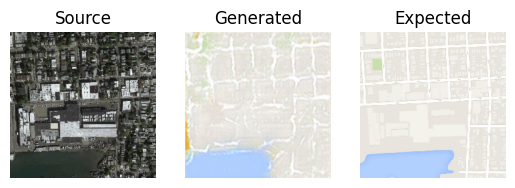

In [ ]:
[X1, X2] = dataset
ix = randint(0, len(X1),1)
src_image,tar_image = X1[ix], X2[ix]
gen_image = g_model.predict(src_image)
plot_images(src_image, gen_image, tar_image)

1/1 [==============================] - 0s 21ms/step


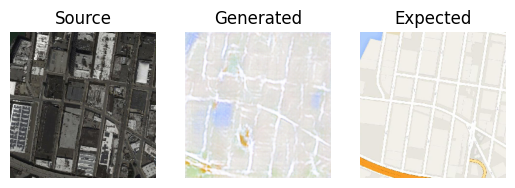

In [ ]:
[X1, X2] = dataset
ix = randint(0, len(X1),1)
src_image,tar_image = X1[ix], X2[ix]
gen_image = g_model.predict(src_image)
plot_images(src_image, gen_image, tar_image)

# Testing on new images

In [ ]:
def plot_images_2(src_img, gen_img):
  images = vstack((src_img, gen_img))
  images = (images + 1 ) / 2.0
  titles = ['Source', 'Generated']

  for i in range(len(images)):
    plt.subplot(1, 3, 1+i)
    plt.axis('off')
    plt.imshow(images[i])
    plt.title(titles[i])
  plt.show()

In [ ]:

img1 = cv2.imread('/content/im.jpg',1)
img2 = cv2.imread('/content/img.jpg',1)

In [ ]:
image1 = cv2.resize(img1,(256,256)) #width,height
image2 = cv2.resize(img2,(256,256))

image1 = (image1.astype('float32')/ 127.5) - 1.0
image2 = (image2.astype('float32')/ 127.5) - 1.0

image1 = np.expand_dims(image1, axis=0)
image2 = np.expand_dims(image2, axis=0)

In [ ]:
gen_image1 = g_model.predict(image1)
gen_image2 = g_model.predict(image2)

1/1 [==============================] - 0s 58ms/step


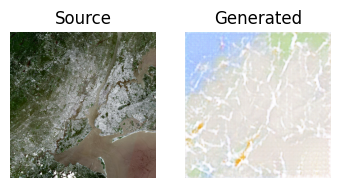

In [ ]:
plot_images_2(image1, gen_image1)

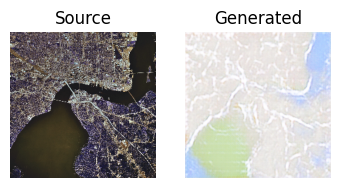

In [ ]:
plot_images_2(image2,gen_image2)